# Coursework 4

### PLAGIARISM/COLLUSION DECLARATION

 

Coursework submitted for assessment must be the original work of you and your group. Assignments are subjected to regular checks for plagiarism and/or collusion. Plagiarism is the presentation of another person’s thoughts or words (those outside your group) as if they were your own. Collusion involves obtaining help from someone outside your group to complete your work. In preparing your coursework, you should not seek help, or copy from any other person or source, including the

Internet, without proper and explicit acknowledgement.

 

There is a procedure in place for you to declare individual contributions within your group for courswork. You must declare the contributions fairly and accurately.

 

You must not disclose your solutions or insights related to coursework with anyone else, including future students or the Internet.

 

By acknowledging the the statements above, you are declaring that both this and all subsequent pieces of coursework are, and will remain, the original work of you and your group.

 

* Submissions will not be accepted without the aforementioned declaration.

 

* Members of a group are deemed to have collective responsibility for the integrity for work submitted and are liable for any penalty imposed, proportionate to their contributions.

In [1]:
using JLD2,FileIO

In [2]:
Base.@kwdef mutable struct CourseWork_4
    
    CID::Int
    Plagiarism_declare::Union{Missing,Bool}
    
    # 11. MRI CS Recovery: ADMM
    
    Q11_data_Z1::Matrix
    Q11_data_Z2::Matrix
    Q11_data_U1::Matrix
    Q11_data_U2::Matrix
    Q11_data_Omega::Matrix
    Q11_data_y::Vector
    Q11_data_lambda_1::Float64
    Q11_data_lambda_2::Float64
    Q11_data_rho::Float64
    
    Q11_1_ans_X::Union{Missing,Matrix}
    Q11_2_ans_Z1::Union{Missing,Matrix}
    Q11_2_ans_Z2::Union{Missing,Matrix}
    Q11_3_ans_U1::Union{Missing,Matrix}
    Q11_3_ans_U2::Union{Missing,Matrix}
    Q11_4_ans_R::Union{Missing,Matrix}
    Q11_5_ans_S::Union{Missing,Matrix}
    Q11_6_ans_X::Union{Missing,Matrix}
    
    # 12. Blind Deconvolution: Convex Relaxation and ADMM
    
    Q12_data_Z1::Matrix
    Q12_data_Z2::Matrix
    Q12_data_U1::Matrix
    Q12_data_U2::Matrix
    Q12_data_y::Vector
    Q12_data_lambda_1::Float64
    Q12_data_lambda_2::Float64
    Q12_data_rho::Float64
    
    Q12_1_ans_X::Union{Missing,Matrix}
    Q12_2_ans_Z1::Union{Missing,Matrix}
    Q12_2_ans_Z2::Union{Missing,Matrix}
    Q12_3_ans_U1::Union{Missing,Matrix}
    Q12_3_ans_U2::Union{Missing,Matrix}
    Q12_4_ans_R::Union{Missing,Matrix}
    Q12_5_ans_S::Union{Missing,Matrix}
    Q12_6_ans_X::Union{Missing,Matrix}
    Q12_7_ans_s::Union{Missing,Vector}
    Q12_7_ans_h::Union{Missing,Vector}
    
    # 13. Neural Network Training: Block Coordinate Descent
    
    Q13_data_Y::Matrix
    Q13_data_X::Matrix
    Q13_data_Ytest::Matrix
    Q13_data_Xtest::Matrix
    Q13_data_X1::Matrix
    Q13_data_Z1::Matrix
    Q13_data_Z2::Matrix
    Q13_data_alpha::Float64
    
    Q13_1_ans_W1::Union{Missing,Matrix}
    Q13_1_ans_W2::Union{Missing,Matrix}
    Q13_2_ans_X1::Union{Missing,Matrix}
    Q13_3_ans_Z1::Union{Missing,Matrix}
    Q13_3_ans_Z2::Union{Missing,Matrix}
    Q13_4_ans_g::Union{Missing,Matrix}
    Q13_5_ans_f::Union{Missing,Vector}
    Q13_5_ans_gx::Union{Missing,Vector}
    Q13_5_ans_l::Union{Missing,Vector}
    Q13_5_ans_ltest::Union{Missing,Vector}
    
    
end

CourseWork_4

In [3]:

A = JLD2.load("Banthia Dev2016674StudentFile (5).jld2");

A = A[ "CourseWork_4" ];

In [4]:
using Pkg
Pkg.add("FFTW")


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [14]:
using LinearAlgebra
using FFTW

omega = A.Q11_data_Omega

Z1 = A.Q12_data_Z1
Z2 = A.Q12_data_Z2
U1 = A.Q12_data_U1
U2 = A.Q12_data_U2
y = A.Q12_data_y
lambda1 = A.Q12_data_lambda_1
lambda2 = A.Q12_data_lambda_2
rho = A.Q12_data_rho

A.Q12_6_ans_X
A.Q12_7_ans_s
A.Q12_7_ans_h

function dct_columns(matrix::Matrix{Float64})
    return mapslices(dct, matrix, dims=1)
end

function idct_columns(matrix::Matrix{Float64})
    return mapslices(idct, matrix, dims=1)
end


function create_sparse_row_vector(m, n, k)

    indices = []

    for i in 1:m  
        j = k + 1 - i 
        if j >= 1 && j <= n 
            push!(indices, i)  
        end
    end

    total_size = m * n  
    sparse_vector = zeros(Int, 1, total_size)

    for i in indices
        col_index = (k + 1 - i - 1) * m + i 
        if col_index >= 1 && col_index <= total_size 
            sparse_vector[1, col_index] = 1
        end
    end

    return sparse_vector
end


function convolution_matrix(m,n)

    conv = zeros(m, m*n) 
    for k in 1:(m)
        sparse_row = create_sparse_row_vector(m, n, k)
        conv[k,:] = sparse_row

    end

    return conv
end

function X_next(conv, rho, y, U1, Z1, U2, Z2)

    temp = conv' * conv
    row_num = size(temp)[1]
    col_num = size(temp)[2]
    scaling_matrix = inv(temp + 2*rho*Matrix(I, row_num, col_num) )

    X_temp = scaling_matrix * ((conv' * y) + vec(U1) + vec(rho*Z1) + vec(idct_columns(U2)) + vec(idct_columns(Z2)))
    return X_temp

end

function singular_value_thresholding(Z1, tau)

    U, S, V = svd(Z1)
    S_thresholded = max.(S .- tau, 0)
    return U * Diagonal(S_thresholded) * V'
    
end

function row_thresholding(X, λ)

    Z = similar(X)
    for i in 1:size(X, 1)
        row = X[i, :]  
        norm_row = norm(row, 2)  
        
        if norm_row <= λ
            Z[i, :] .= 0.0
        else
            Z[i, :] .= (1 - λ / norm_row) * row
        end
    end
    
    return Z
end

function update_U(U1, rho, Z1, X, U2, Z2)
    U1 = U1 + rho*(Z1 - X)
    U2 = U2 + rho*(Z2 - dct_columns(X))

    return U1, U2

end


function ADMM(conv, rho, y, U1, Z1, U2, Z2, lambda1, lambda2)


    for i in 1:200


        Z1_prev = Z1
        Z2_prev = Z2

        X = X_next(conv, rho, y, U1, Z1, U2, Z2)
        X = reshape(X, (m,n))

        z1_threshold =  lambda1/rho
        z1_target_matrix = X - U1/rho
        Z1 = singular_value_thresholding(z1_target_matrix, z1_threshold)

        z2_threshold = lambda2/rho
        z2_target_matrix = dct_columns(X) - U2/rho
        Z2 = row_thresholding(z2_target_matrix, z2_threshold)

        r1 = Z1 - X
        r2 = Z2 - dct_columns(X)
        primal_residual = sqrt(norm(r1, 2)^2 + norm(r2, 2)^2)
        println(primal_residual)
    
        s1 = rho * (Z1 - Z1_prev)
        s2 = rho * idct_columns(Z2 - Z2_prev)
        dual_residual = sqrt(norm(s1, 2)^2 + norm(s2, 2)^2)

        U1 = U1 + rho*(Z1 - X)
        U2 = U2 + rho*(Z2 - dct_columns(X))

    end

    return X, Z1

end

Z1_prev = Z1
Z2_prev = Z2

m = size(U1)[1]
n = size(U1)[2]
conv = convolution_matrix(m,n)
X = X_next(conv, rho, y, U1, Z1, U2, Z2)
X = reshape(X, (m,n))

z1_threshold =  lambda1/rho
z1_target_matrix = X - U1/rho
Z1 = singular_value_thresholding(z1_target_matrix, z1_threshold)

z2_threshold = lambda2/rho
z2_target_matrix = dct_columns(X) - U2/rho
Z2 = row_thresholding(z2_target_matrix, z2_threshold)

A.Q12_1_ans_X = X
A.Q12_2_ans_Z1 = Z1
A.Q12_2_ans_Z2 = Z2

U1, U2 = update_U(U1, rho, Z1, X, U2, Z2)
A.Q12_3_ans_U1 = U1
A.Q12_3_ans_U2 = U2

r1 = Z1 - X
r2 = Z2 - dct_columns(X)
primal_residual = vcat(r1, r2)
A.Q12_4_ans_R = primal_residual

s1 = rho * (Z1 - Z1_prev)
s2 = rho * idct_columns(Z2 - Z2_prev)
dual_residual = s1 + s2
A.Q12_5_ans_S = dual_residual


X, Z1 = ADMM(conv, rho, y, U1, Z1, U2, Z2, lambda1, lambda2)





1.201204192652598
0.07166518766046416
0.01487678968827425
0.005718730138385131
0.004343573331396532
0.004245434138392539
0.004447151194424987
0.004773468701331473
0.005184492455745062
0.005678184123666047
0.006269177014135009
0.006985463254043427
0.007872706569064821
0.009006521044634393
0.010520169114161397
0.012669412280578433
0.015996950652953125
0.02178217086511277
0.03329715026565332
0.05882041272605751
0.07450644377385222
0.06868360631699537
0.057664531620127385
0.06702920910781696
0.08875888793996221
0.09088138060699112
0.11567854863371327
0.1413038162342705
0.1606112804619053
0.16879774781279722
0.16898654713241693
0.2141640260708541
0.24951540837486247
0.2503675007053248
0.2507920452689135
0.24821574645907943
0.24859828333293912
0.25479284082697673
0.24762449077823048
0.23518383326408132
0.22502948941127238
0.19364966229014421
0.1480615289867304
0.1309188701608116
0.11416176738893567
0.07679736081540081
0.04994464911010347
0.03322665301588218
0.02401733158643063
0.019165733535

([-0.37201013238493197 -0.11223574735062093 … 1.2809795070011516 0.7866485371813039; -0.4908344710852727 -0.6815808150259756 … -0.26300202889788105 -2.082289663302947; … ; 0.709638704207449 -0.5731834252769687 … 0.9352088761441493 -0.16464434274952955; -0.0018964085254914644 0.076063344979449 … 0.2412902353572805 -0.18137739040494671], [0.0019278722676692303 0.0003676743332693808 … -0.0020196841738400295 0.0009961740335808651; -0.0014718535131557585 0.0009417962166842058 … 0.00145121451260109 -0.0028879962710929045; … ; 0.008426226538609067 0.009461425088816254 … 0.0017369742465036845 -0.0031852533026396927; 0.009111719900029552 0.001489123309777623 … -0.003312246489341864 0.0012923522210248329])

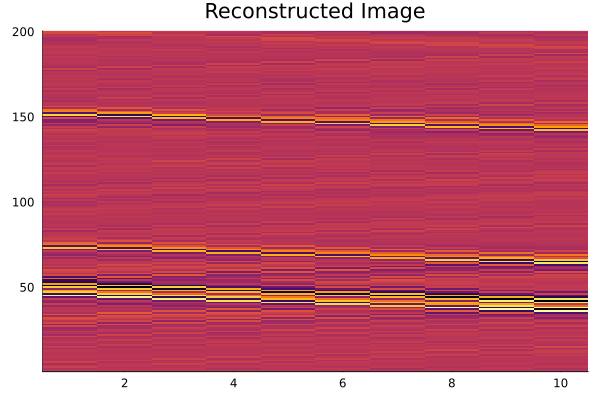

In [16]:
using Images
using FileIO
using Plots

#since Z1 is constrained to be as close as possible to X, we use Z1 to extract s and h. Using X for the same does not yield the same results (Don't know why)

X_final = Z1
s, sigma, h = svd(X_final)

clean_signal = s[:,1]
kernel = h[:,1]

A.Q12_6_ans_X = X_final
A.Q12_7_ans_s = clean_signal
A.Q12_7_ans_h = kernel

item = conv * vec(clean_signal*kernel')

p1 = heatmap(X_final, title="Reconstructed Image", legend=false)
plot(p1)

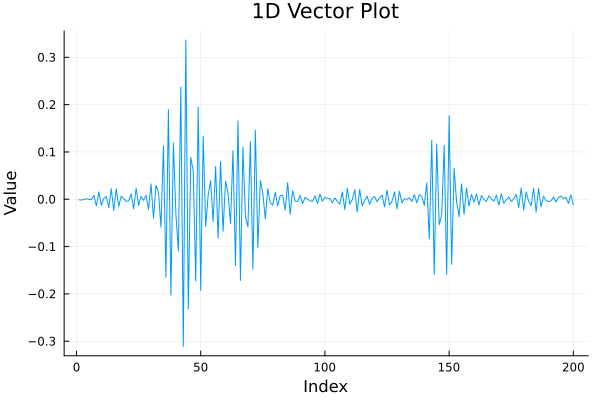

In [10]:
plot(clean_signal, title="1D Vector Plot", xlabel="Index", ylabel="Value", legend=false)

In [24]:
using LinearAlgebra

y = A.Q13_data_Y
X = A.Q13_data_X
y_test = A.Q13_data_Ytest
X_test = A.Q13_data_Xtest
X1 = A.Q13_data_X1
Z1 = A.Q13_data_Z1
Z2 = A.Q13_data_Z2
alpha = A.Q13_data_alpha

# alpha = 0.5


function update_W1(Z1, X)

    W1 = alpha*(Z1*X')*pinv(X*X')
    grad_W1 = norm(alpha*(Z1 - W1*X)*X')

    return W1, grad_W1
end

function update_W2(Z2, X1)
    W2 = alpha*(Z2*X1')*pinv(X1*X1')
    grad_W2 = norm(alpha*(Z2 - W2*X1)*X1')

    return W2, grad_W2
end

function update_X1(W2, Z2, Z1)

    X1 = pinv(W2'*W2 + I)*(W2'*Z2 - max.(Z1, 0))

    grad_X1 = norm((W2' * Z2) - (W2' * W2 * X1) + X1 - max.(Z1, 0))

    return X1, grad_X1
end



function proximal_relu_matrix(a::AbstractMatrix, b::AbstractMatrix, λ::Real)

    proximal_element(a_ij, b_ij) = begin
        term = a_ij + λ * b_ij
        threshold = -1*(sqrt(λ * (λ + 1)) - λ) * a_ij

        if (term >= 0 && b_ij >= 0) || ((threshold <= λ * b_ij)  && (λ * b_ij < 0))
        
            return (a_ij + λ * b_ij) / (1 + λ)

        elseif (-a_ij <= λ * b_ij) && (λ * b_ij <= threshold) && (threshold < 0)
            return b_ij

        elseif term < 0
            return min(b_ij, 0)
        else
            error("Unexpected case encountered at element ($a_ij, $b_ij)")
        end
    end
    return map(proximal_element, a, b)
end


W1, grad_W1 = update_W1(Z1, X)
W2, grad_W2 = update_W2(Z2, X1)
X1, grad_X1 = update_X1(W2, Z2, Z1)

a = y
b = W2*X1

Z2 = proximal_relu_matrix(a::AbstractMatrix, b::AbstractMatrix, alpha)

a = X1
b = W1*X

Z1 = proximal_relu_matrix(a::AbstractMatrix, b::AbstractMatrix, alpha)


function BCD(Z1, X, Z2, X1, W1, W2, alpha, y)

    for i in 1:100
        W1, grad_W1 = update_W1(Z1, X)
        W2, grad_W2 = update_W1(Z2, X1)
        X1, grad_X1 = update_X1(W2, Z2, Z1)
        println(norm(grad_X1))

        a = y
        b = W2*X1
        Z2 = proximal_relu_matrix(a, b, alpha)

        a = X1
        b = W1*X
        Z1 = proximal_relu_matrix(a::AbstractMatrix, b::AbstractMatrix, alpha)

    end

end

println(norm(X))
BCD(Z1, X, Z2, X1, W1, W2, alpha, y)





245.33662930354097
310.65509502036747
286.2710314070101
277.0245143704505
270.8738001456671
265.68882464143934
261.1202912966277
256.9615871457982
253.12972463726234
249.56748104527364
246.24290792559032
243.1191927619009
240.18450363031653
237.41067597759732
234.7827827895397
232.29042907761183
229.9199682502723
227.6589394799289
225.49493592948158
223.4242951866061
221.4390508677781
219.52701867107857
217.69201353271762
215.92492020471687
214.21732073889962
212.57339323843146
210.98554814120172
209.4497331823309
207.95972170222836
206.51830129985402
205.1206975668263
203.76352646765343
202.44608967964672
201.16599219535664
199.92056686003542
198.7087137448516
197.527134335557
196.37511993663423
195.2463625361974
194.14758165737857
193.0763920991503
192.03023647848872
191.00737135204665
190.00870150168618
189.03186837990023
188.0760148019372
187.13930444468636
186.22195691200483
185.32344968469476
184.44329112298112
183.579535547746
182.7322939387016
181.90108670937659
181.08518422098